In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [2]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [3]:
data_loc = '/gpfs/slac/atlas/fs1/d/rafaeltl/public/ML/L1RNN/datasets_2020_ff/'

In [4]:
file_str = 'Jan06_FlavFix_smear_1_std_xtd_zst.h5'

In [5]:
f5 = h5py.File(data_loc+file_str, 'r')

In [6]:
x_train = np.array( f5['x_train'] )
y_train = to_categorical ( np.array( f5['y_train'] ) )
w_train = np.array( f5['w_train'] )

In [7]:
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, LSTM, Masking, Input, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1

In [8]:
from tensorflow.keras import regularizers

In [9]:
def lstmmodel(max_len, n_var, rec_units, ndense=[10], rec_layer='LSTM', 
              l2_reg=0.0001, rec_act='sigmoid', extra_lab='none', vscale='VarianceScaling'):
    
    track_inputs = Input(shape=(max_len, n_var,))
    
    if 'LSTM' in rec_layer:
        if l2_reg > 1e-6:
            hidden = LSTM(units=rec_units,
                  recurrent_activation = rec_act,
                  kernel_initializer = vscale, 
                  kernel_regularizer = regularizers.l2(l2 = l2_reg),
                  name = 'lstm1')(track_inputs)
        else:
            hidden = LSTM(units=rec_units,
                  kernel_initializer = vscale,
                  name = 'lstm1')(track_inputs)
    if 'GRU' in rec_layer:
        hidden = GRU(units=rec_units,
                  kernel_initializer = vscale, 
                  kernel_regularizer = regularizers.l2(l2 = l2_reg),
                  name = 'lstm1')(track_inputs)

        
    
    for ind,nd in enumerate(ndense):
        hidden = Dense(nd, activation='relu', kernel_initializer='lecun_uniform', name=f'dense_{ind}' )(hidden)
    
    output = Dense(3, activation='softmax', kernel_initializer='lecun_uniform', name = 'output_sigmoid')(hidden)
    
    model = Model(inputs=track_inputs, outputs=output)
    
    d_layers = ''.join([ str(dl) for dl in ndense ])

    init_name = 'KIvs'
    if 'VarianceScaling' not in vscale and 'glorot_uniform' in vscale:
        init_name = 'KIgo'
        
    mname = f'rnn_{rec_layer}_{rec_units}_{d_layers}_nomask_{init_name}_KRl2.{l2_reg}_recAct.{rec_act}' #LSTM kernel regularizer
    if 'none' not in extra_lab:
        mname += f'_{extra_lab}'
    
    return model, mname

#     mask = Masking( mask_value=0, name="masking_1")(track_inputs)
##########################################
#                   use_bias=False,
#                   activation='relu',
#                   recurrent_activation='relu',
#                   kernel_regularizer = regularizers.l1_l2(l1= 0.001, l2 = 0.0001), 
#                   bias_regularizer = regularizers.l1_l2(l1= 1, l2 = 1), 
#                   activity_regularizer=regularizers.l1_l2(l1= 0.001, l2 = 0.0001),
##########################################


In [10]:
# model, model_name = lstmmodel(15, 6, 50, [10], rec_layer='GRU')
# model, model_name = lstmmodel(15, 6, 20, [10], rec_layer='LSTM', l2_reg=0.0001, rec_act='tanh')
# model, model_name = lstmmodel(15, 6, 1, [10], l2_reg=0, rec_layer='LSTM')
model, model_name = lstmmodel(15, 6, 10, [10], l2_reg=0, rec_layer='LSTM', vscale='glorot_uniform')

In [11]:
model.summary()
print(model_name)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 6)]           0         
_________________________________________________________________
lstm1 (LSTM)                 (None, 10)                680       
_________________________________________________________________
dense_0 (Dense)              (None, 10)                110       
_________________________________________________________________
output_sigmoid (Dense)       (None, 3)                 33        
Total params: 823
Trainable params: 823
Non-trainable params: 0
_________________________________________________________________
rnn_LSTM_10_10_nomask_KIgo_KRl2.0_recAct.sigmoid


In [13]:
model_json = model.to_json()
with open(f'keras/model_{model_name}_arch.json', "w") as json_file:
    json_file.write(model_json)

In [14]:
# adam = Adam(learning_rate=0.01)
model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [16]:
model_output = f'keras/model_{model_name}_weights.h5'

In [17]:
train = True

In [18]:
if train:
    history = model.fit( x_train , y_train,
            batch_size=2**14,
            # epochs=10,
            epochs=150,
            validation_split=0.1,
            shuffle = True,
            sample_weight= w_train,
            callbacks = [
                EarlyStopping(verbose=True, patience=20, monitor='val_accuracy'),
                ModelCheckpoint(model_output, monitor='val_accuracy', verbose=True, save_best_only=True)
                ],
            verbose=True
            )
    
model.load_weights(model_output)

Epoch 1/150
39/39 [==============================] - 9s 208ms/step - loss: 1.0747 - accuracy: 0.4402 - val_loss: 1.0294 - val_accuracy: 0.4870

Epoch 00001: val_accuracy improved from -inf to 0.48704, saving model to keras/model_rnn_LSTM_10_10_nomask_KIgo_KRl2.0_recAct.sigmoid_weights.h5
Epoch 2/150
39/39 [==============================] - 3s 72ms/step - loss: 1.0125 - accuracy: 0.4997 - val_loss: 0.9630 - val_accuracy: 0.5487

Epoch 00002: val_accuracy improved from 0.48704 to 0.54871, saving model to keras/model_rnn_LSTM_10_10_nomask_KIgo_KRl2.0_recAct.sigmoid_weights.h5
Epoch 3/150
39/39 [==============================] - 3s 71ms/step - loss: 0.9409 - accuracy: 0.5714 - val_loss: 0.8838 - val_accuracy: 0.6221

Epoch 00003: val_accuracy improved from 0.54871 to 0.62212, saving model to keras/model_rnn_LSTM_10_10_nomask_KIgo_KRl2.0_recAct.sigmoid_weights.h5
Epoch 4/150
39/39 [==============================] - 3s 72ms/step - loss: 0.8744 - accuracy: 0.6270 - val_loss: 0.8526 - val_accu

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 6)]           0         
_________________________________________________________________
lstm1 (LSTM)                 (None, 10)                680       
_________________________________________________________________
dense_0 (Dense)              (None, 10)                110       
_________________________________________________________________
output_sigmoid (Dense)       (None, 3)                 33        
Total params: 823
Trainable params: 823
Non-trainable params: 0
_________________________________________________________________


In [20]:
x_test = np.array( f5['x_test'] )
y_test = to_categorical ( np.array( f5['y_test'] ) )

In [21]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [22]:
import importlib

In [23]:
importlib.reload(plotting)

<module 'plotting' from '/gpfs/slac/atlas/fs1/u/rafaeltl/ML/L1BTag/Mar28/hls-rnn-btag/notebooks/plotting.py'>

In [24]:
pred_test = model.predict(x_test, batch_size=2**10)

In [25]:
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(pred_test, axis=1))))

Accuracy: 0.7169732246798604


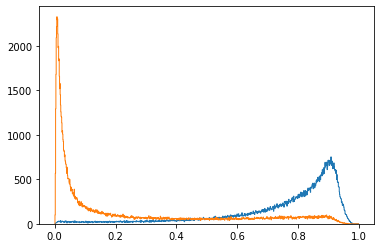

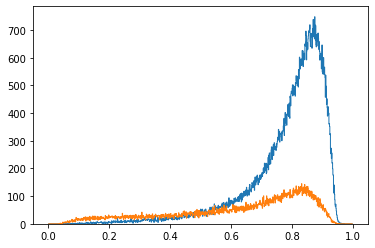

In [26]:
pb_b = pred_test[:,0] [y_test[:,0] == 1]
pc_b = pred_test[:,1] [y_test[:,0] == 1]
pl_b = pred_test[:,2] [y_test[:,0] == 1]
    
pc_c = pred_test[:,1] [y_test[:,1] == 1]
pb_c = pred_test[:,0] [y_test[:,1] == 1]
    
pl_l = pred_test[:,2] [y_test[:,2] == 1]
pb_l = pred_test[:,0] [y_test[:,2] == 1]

plt.Figure()

plt.hist( pb_b/(pb_b+pl_b), range=(0,1), bins=1000, histtype='step' )
plt.hist( pb_l/(pb_l+pl_l), range=(0,1), bins=1000, histtype='step' )

plt.show()


plt.Figure()

plt.hist( pb_b/(pb_b+pc_b), range=(0,1), bins=1000, histtype='step' )
plt.hist( pb_c/(pb_c+pc_c), range=(0,1), bins=1000, histtype='step' )

plt.show()

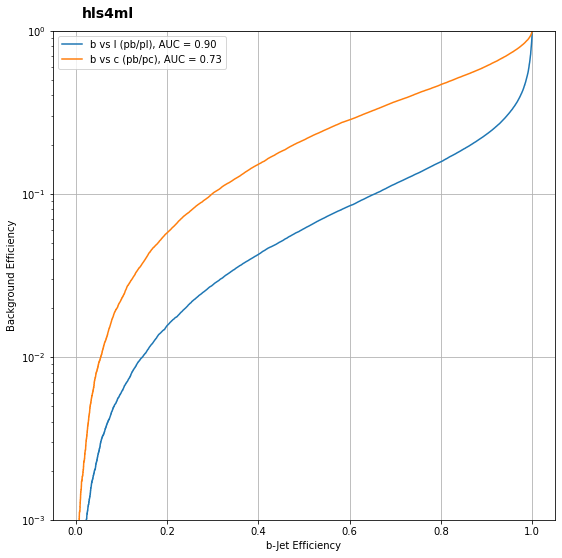

In [27]:
plt.figure(figsize=(9,9))
_ = plotting.makeRoc(y_test, pred_test)

In [28]:
for layer in model.layers:
    print(layer.name)
#     plt.Figure()
    
    this_wgts = layer.get_weights()
#     if len(this_wgts) < 1: continue
    print(layer.get_config())
    
    for wgt in this_wgts:
        print(wgt)
        print()
#     max_wgts = np.max(this_wgts)
#     min_wgts = np.min(this_wgts)
#     plt.hist(this_wgts, bins=100, range=(min_wgts, max_wgts))
#     plt.xlabel(f'{layer.name}')
#     plt.show

input_1
{'batch_input_shape': (None, 15, 6), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}
lstm1
{'name': 'lstm1', 'trainable': True, 'dtype': 'float32', 'return_sequences': False, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'units': 10, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'recurrent_initializer': {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'unit_forget_bias': True, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0, 'implementation': 2}
[[ 7.11858571e-01  6.83024377e-02  1.64593086e-01  1.85972527e-01
  -1.21771783e-